In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

from numba import jit
import numpy as np

from advection_solver.util import roll

In [2]:
@jit(nopython=True)
def vanleer_tendency_loop(c, u, dx, dt):
    """
    Second-order flux-limited (VanLeer) tendency with periodic boundary

    Args:
      c: 1d numpy array, density field
      u: 1d numpy array, wind field
      dx: float, grid spacing (assume uniform)
      dt: float, time step

    Returns:
      1d numpy array with same shape as `c`

    Reference: The "mono-5" limiter in
    Lin, S.-J., et al. (1994). "A class of the van Leer-type transport schemes and its application to the moisture transport in a general circulation model."
    """

    nx = c.size

    # re-stagger to C-grid, pointing from box[i-1] to box[i]
    # remove this step if input wind is already staggered
    # u = 0.5*(u+np.roll(u, 1))
    cfl = u*dt/dx

    c_l = roll(c, 1)  # so c_l[i] == c[i-1], with periodic boundary
    c_r = roll(c, -1)

    mismatch = np.empty(nx)  # left-right difference in piecewise-linear reconstruction
    flux = np.empty(nx)  # flux[i] is the flux from box[i-1] to box[i]

    delta = c - c_l
    delta_avg = (delta + roll(delta, -1))/2

    # compute slope (mismatch) in piecewise-linear reconstruction
    for i in range(nx):
        # compute local limiter
        c_max = max(c[i], c_l[i], c_r[i])  # upper boundary
        c_min = min(c[i], c_l[i], c_r[i])  # lower boundary
        mismatch[i] = np.sign(delta_avg[i])*min(abs(delta_avg[i]),
                                                2*(c[i]-c_min),
                                                2*(c_max-c[i]))

    # compute flux from slope
    mismatch_l = roll(mismatch, 1)
    for i in range(nx):
        if u[i] > 0:
            flux[i] = u[i]*(c_l[i]+mismatch_l[i]/2*(1-cfl[i]))
        else:
            flux[i] = u[i]*(c[i]-mismatch[i]/2*(1+cfl[i]))

    tendency = flux - roll(flux, -1)
    return tendency*dt/dx

In [3]:
@jit(nopython=True)
def vanleer_tendency_vect(c, u, dx, dt):
    '''
    Vectorized version of advection tendency with periodic boundary

    Args:
      c: 1d numpy array, density field
      u: 1d numpy array, wind field
      dx: float, grid spacing (assume uniform)
      dt: float, time step

    Returns:
      1d numpy array with same shape as `c`
    '''

    # re-stagger to C-grid, pointing from box[i-1] to box[i]
    # remove this step if input wind is already staggered
    # u = 0.5*(u+np.roll(u, 1))

    c_l = roll(c, 1)  # so c_l[i] == c[i-1], with periodic boundary
    c_r = roll(c, -1)
    
    delta = c - c_l
    delta_avg = (delta + roll(delta, -1))/2
            
    # can also use np.maximum.reduce()
    c_max = np.maximum(c, np.maximum(c_l, c_r)) # upper boundary
    c_min = np.minimum(c, np.minimum(c_l, c_r)) # lower boundary
    mismatch = np.sign(delta_avg)*np.minimum(np.abs(delta_avg), np.minimum(2*(c-c_min), 2*(c_max-c)))
        
    # compute flux from slope
    mismatch_l = roll(mismatch, 1)

    cfl = u*dt/dx
    flux_right = np.maximum(u, 0) * (c_l + mismatch_l*(1-cfl)/2)
    flux_left = np.minimum(u, 0) * (c - mismatch*(1+cfl)/2)
    flux = flux_right + flux_left
    
    tendency = flux - roll(flux, -1)

    return tendency*dt/dx

In [4]:
nx = 100
Lx = 1
dx = Lx/nx
dt = 0.01
u = np.ones(nx) * -0.5
c0 = np.zeros(nx)
c0[int(nx*0.2):int(nx*0.4)] = 1.0

In [6]:
%%time
# run at least twice to jit-compile
nt = 10000

c1 = c0.copy()
for _ in range(nt):
    c1 += vanleer_tendency_loop(c1, u, dx, dt)

CPU times: user 81.6 ms, sys: 1.77 ms, total: 83.3 ms
Wall time: 82.7 ms


In [8]:
%%time
# run at least twice to jit-compile
nt = 10000

c2 = c0.copy()
for _ in range(nt):
    c2 += vanleer_tendency_vect(c2, u, dx, dt)
    
# with numba roll, almost as fast as original.
# will be 4x slower without jit-compiling the function body (why?)
# further 2x slower if np.roll is used

CPU times: user 109 ms, sys: 2.33 ms, total: 112 ms
Wall time: 111 ms


In [9]:
np.array_equal(c1, c2)

True

Text(0.5,1,'flux-limited scheme')

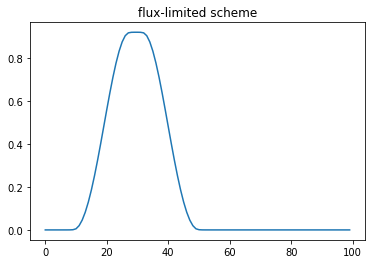

In [10]:
plt.plot(c1)
plt.title('flux-limited scheme')